# ethan chung

In [1]:
import pandas as pd
from transformers import GPT2Tokenizer, TFGPT2LMHeadModel
import tensorflow as tf
import matplotlib.pyplot as plt
import re

tf.config.list_physical_devices('GPU')

2024-10-24 07:19:45.243650: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-24 07:19:45.261721: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-24 07:19:45.267344: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-24 07:19:45.282025: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-24 07:19:47.284851: W tensorflow/compiler/tf2

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## load datasets (and clean URLs)

In [2]:
# Load the dataset using pandas (Assuming your CSV has a column "joke")
df = pd.read_csv("data.csv")

# Define a regex pattern to match URLs
url_pattern = r'http\S+|www\S+|https\S+'

# Remove URLs from the jokes column using the regex pattern
df['Joke'] = df['Joke'].apply(lambda text: re.sub(url_pattern, '', text))

# Extract the cleaned jokes from the dataframe
jokes = df['Joke'].tolist()

display(df['Joke'])

0       What did the bartender say to the jumper cable...
1       Don't you hate jokes about German sausage? The...
2       Two artists had an art contest... It ended in ...
3       Why did the chicken cross the playground? To g...
4        What gun do you use to hunt a moose? A moosecut!
                              ...                        
1617    What do you call a camel with 3 humps? Humphre...
1618    Two fish in a tank. [x-post from r/Jokes] One ...
1619            "Stay strong!" I said to my wi-fi signal.
1620    Why was the tomato blushing? Because it saw th...
1621      What is heavy forward but not backward? **ton**
Name: Joke, Length: 1622, dtype: object

## init model

In [3]:
# Load GPT-2 tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
# Load pre-trained GPT-2 model
model = TFGPT2LMHeadModel.from_pretrained('gpt2')

# Add padding token for GPT-2 since GPT-2 does not have a pad token by default
tokenizer.pad_token = tokenizer.eos_token

# Tokenize the jokes
tokenized_jokes = tokenizer(jokes, return_tensors='tf', padding=True, truncation=True, max_length=128)

# Extract the tokenized input IDs and attention masks
x_input_ids = tokenized_jokes['input_ids']
x_attention_masks = tokenized_jokes['attention_mask']

# Create the labels for language modeling (same as input_ids)
labels = x_input_ids[:, 1:]
input_ids = x_input_ids[:, :-1]
attention_masks = x_attention_masks[:, :-1]

# Create a TensorFlow dataset with inputs and labels
train_dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': input_ids, 'attention_mask': attention_masks}, labels))

# Shuffle and batch the dataset for training
train_dataset = train_dataset.shuffle(len(jokes)).batch(2)  # Adjust batch size as needed

# Compile the model with Adam optimizer and custom loss function
optimizer = tf.keras.optimizers.AdamW(learning_rate=3e-5)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='loss', 
    patience=3,
    restore_best_weights=True
)

2024-10-24 07:19:51.130801: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31134 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:0b:00.0, compute capability: 7.0
All PyTorch model weights were used when initializing TFGPT2LMHeadModel.

All the weights of TFGPT2LMHeadModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


In [4]:
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

# Fine-tune the GPT-2 model on the jokes dataset
history = model.fit(train_dataset, 
                    epochs=10, 
                    callbacks=[early_stopping])

Epoch 1/10


I0000 00:00:1729754415.765082 2980028 service.cc:146] XLA service 0x151f60b52c50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729754415.765102 2980028 service.cc:154]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2024-10-24 07:20:15.771781: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-24 07:20:15.790960: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
I0000 00:00:1729754415.849408 2980028 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


811/811 [==============================] - 66s 46ms/step - loss: 1.4805
Epoch 2/10
811/811 [==============================] - 37s 45ms/step - loss: 1.1923
Epoch 3/10
811/811 [==============================] - 37s 46ms/step - loss: 1.0191
Epoch 4/10
811/811 [==============================] - 37s 45ms/step - loss: 0.8627
Epoch 5/10
811/811 [==============================] - 37s 45ms/step - loss: 0.7215
Epoch 6/10
811/811 [==============================] - 37s 45ms/step - loss: 0.5928
Epoch 7/10
811/811 [==============================] - 37s 45ms/step - loss: 0.4882
Epoch 8/10
811/811 [==============================] - 37s 46ms/step - loss: 0.4020
Epoch 9/10
811/811 [==============================] - 38s 47ms/step - loss: 0.3393
Epoch 10/10
811/811 [==============================] - 38s 46ms/step - loss: 0.2908


In [5]:
# Save the fine-tuned model and tokenizer
model.save_pretrained("./gpt2-joke-model-ablation")
tokenizer.save_pretrained("./gpt2-joke-model-ablation")

('./gpt2-joke-model-ablation/tokenizer_config.json',
 './gpt2-joke-model-ablation/special_tokens_map.json',
 './gpt2-joke-model-ablation/vocab.json',
 './gpt2-joke-model-ablation/merges.txt',
 './gpt2-joke-model-ablation/added_tokens.json')

## plot model loss

Text(0, 0.5, 'Loss')

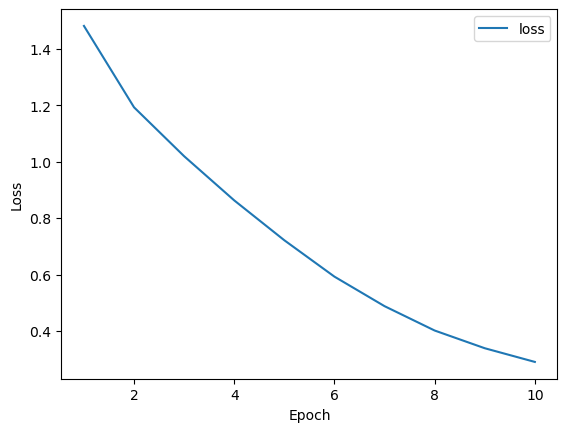

In [6]:
plt_loss = history.history['loss']
plt_epoch = range(1, len(plt_loss) + 1)
plt.plot(plt_epoch, plt_loss, label='loss')

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

## generate jokes

In [7]:
x_tokenizer = GPT2Tokenizer.from_pretrained("./gpt2-joke-model-ablation")
x_model = TFGPT2LMHeadModel.from_pretrained('./gpt2-joke-model-ablation')

# Function to generate jokes from three starting words
def generate_joke(starting_words, max_length=50):
    # Encode the starting words
    input_ids = x_tokenizer.encode(starting_words, return_tensors='tf')
    
    # Create an attention mask (all 1s, since we don't have padding in this example input)
    attention_mask = tf.ones_like(input_ids)
    
    # Generate joke from the model
    output = x_model.generate(
        input_ids,
        attention_mask=attention_mask,  # Explicitly pass attention mask
        max_length=max_length,
        num_return_sequences=1,
        no_repeat_ngram_size=2,
        top_p=0.95,
        temperature=0.8,
        do_sample=True,
        pad_token_id=x_tokenizer.eos_token_id  # Set pad_token_id explicitly to eos_token_id
    )
    
    # Decode the generated joke
    joke = x_tokenizer.decode(output[0], skip_special_tokens=True)
    return joke

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at ./gpt2-joke-model-ablation.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


In [8]:
# List of starting phrases for the jokes
starting_words_list = [
    "What did the",
    "A horse walks",
    "The dog ran",
    "The boy flew",
    "A mosquito ate",
    "The youtuber committed",
    "A rat ratted"
]

# Loop through the starting phrases and generate jokes
for starting_words in starting_words_list:
    print("Joke:", generate_joke(starting_words))

# test what happens when generating same starting
repeat_phrases = ["A fruit fly"] * 3 
for starting_words in repeat_phrases:
    print("Joke:", generate_joke(starting_words))


Joke: What did the name of the man who invented the round table? Sir Cumference.
Joke: A horse walks into a bar... The bartender says, "What is this, a joke?"
Joke: The dog ran into the wall and fell. He couldn't get up and ran away.
Joke: The boy flew into a hotel owned by a dalliance. The bellhop asked if he wanted to dance. "No," he replied.
Joke: A mosquito ate a cartridge and ran away. The cartridge said to him, "I'll catch you later, maaan."
Joke: The youtuber committed suicide after posting a joke about police searches. He was responding to a police search for a suspect in a string of disturbing news. When asked, he replied: "I'm responding in self defense."
Joke: A rat ratted a table In a hotel room in Mexico City, Donald Trump walked into a saloon and told the people there, "Look at this table and take this food."
Joke: A fruit fly and a rabbit are having a dispute... A fruit flies and rabbit cant walk up to the fruit and say, "We have a problem with pesticides."
Joke: A fruit

## sample token view

In [9]:
tokens_to_print = ["what", "did", "the", "joke", "say"]

for token in tokens_to_print:
    token_id = x_tokenizer.encode(token)[0]
    decoded_token = x_tokenizer.decode([token_id])
    print(f"Token: '{token}' | Token ID: {token_id} | Decoded: '{decoded_token}'")


Token: 'what' | Token ID: 10919 | Decoded: 'what'
Token: 'did' | Token ID: 20839 | Decoded: 'did'
Token: 'the' | Token ID: 1169 | Decoded: 'the'
Token: 'joke' | Token ID: 73 | Decoded: 'j'
Token: 'say' | Token ID: 16706 | Decoded: 'say'
